## Prepare drive

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Set data path
#root_path = '/content/drive/My Drive/'
#proj_path = root_path + 'ML_Projects/Bib_Racer/'
!ln -s /content/drive/My\ Drive/ML_Projects/Bib_Racer /content/bib_racer
proj_path = '/content/bib_racer/'
data_path = proj_path + 'data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Install Yolo & prepare to train custom objects
https://github.com/AlexeyAB/darknet/#how-to-train-to-detect-your-custom-objects

### Install Yolo AlexeyAB fork and prepare metadata

In [2]:
%cd /content/
!rm -fr darknet
!git clone https://github.com/AlexeyAB/darknet/
%cd darknet

/content
Cloning into 'darknet'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 13029 (delta 0), reused 1 (delta 0), pack-reused 13025
Receiving objects: 100% (13029/13029), 11.76 MiB | 14.82 MiB/s, done.
Resolving deltas: 100% (8900/8900), done.
/content/darknet


In [0]:
%cd /content/darknet
%cp "$proj_path"Makefile ./
!make

In [0]:
!cp "$data_path"yolo_cfg/yolo-obj.cfg /content/darknet/build/darknet/x64/cfg/
!cp "$data_path"yolo_cfg/obj.names /content/darknet/build/darknet/x64/data/
!cp "$data_path"yolo_cfg/obj.data /content/darknet/build/darknet/x64/data/
#!cp "$data_path"/yolo_cfg/train.txt /content/darknet/build/darknet/x64/data/
!cp "$data_path"yolo_cfg/valid.txt /content/darknet/build/darknet/x64/data/
!cp "$data_path"yolov3.weights /content/darknet/

## Start of bib_detection.py

In [0]:
from google.colab.patches import cv2_imshow
import numpy as np
#import argparse
import cv2
import os

#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True, help="path to input image")
#args = vars(ap.parse_args())

# default parameters
#image_path = "/content/bib_racer/data/images/train_tiny_50files/1024_1452FC8A-D90F-3E10-4BB6-B4B7CE5BB67D.jpg"
image_path = "/content/darknet/data/eagle.jpg"
yolo_dir = "/content/darknet/"
base_dir = "/content/bib_racer/"
confidence_default = 0.5
threshold = 0.25

# load class labels
data_dir = base_dir+"data/"
meta_dir = data_dir+"yolo_cfg/"
#labels = open(meta_dir+"obj.names").read().strip().split("\n")
labels = open("/content/darknet/data/coco.names").read().strip().split("\n")

# load YOLO weights and configuration file
#cfg = meta_dir+"yolo-obj.cfg"
#weight = data_dir+"weights_backup/yolo-obj_4000.weights"
cfg = yolo_dir+"cfg/yolov3.cfg"
weight = yolo_dir+"yolov3.weights"
# load YOLO detector trained on custom dataset
net = cv2.dnn.readNetFromDarknet(cfg, weight)

# determine the output layer names
l_names = net.getLayerNames()
ol_names = [l_names[i[0]-1] for i in net.getUnconnectedOutLayers()]

In [0]:
# load the image
image = cv2.imread(image_path)
(H,W) = image.shape[:2]

# construct a blob from the input image, pass to the YOLO detector and
# grab the bounding boxes and associated probabilities
blob = cv2.dnn.blobFromImage(image, 1, (416,416), swapRB=True, crop=False)
net.setInput(blob)
layer_outputs = net.forward(ol_names)

In [0]:
# initialize some output lists
boxes = []
confidences = []
classIDs = []

# output of YOLO [0:4]: [center_x, center_y, box_w, box_h]
# output of YOLO [4]: confidence
# output of YOLO [5:]: class scores
for output in layer_outputs:
  print(output.shape)
  for detection in output:
    scores = detection[5:]
    classID = np.argmax(scores)
    confidence = scores[classID]

    if confidence > confidence_default:
       (center_x, center_y, width, height) = (detection[0:4] * ([W, H, W, H])).astype("int")
       x = int(center_x - (width/2))
       y = int(center_y - (height/2))
       boxes.append([x, y, int(width), int(height)])
       confidences.append(float(confidence))
       classIDs.append(classID)

(507, 85)
(2028, 85)
(8112, 85)


In [0]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence_default, threshold)

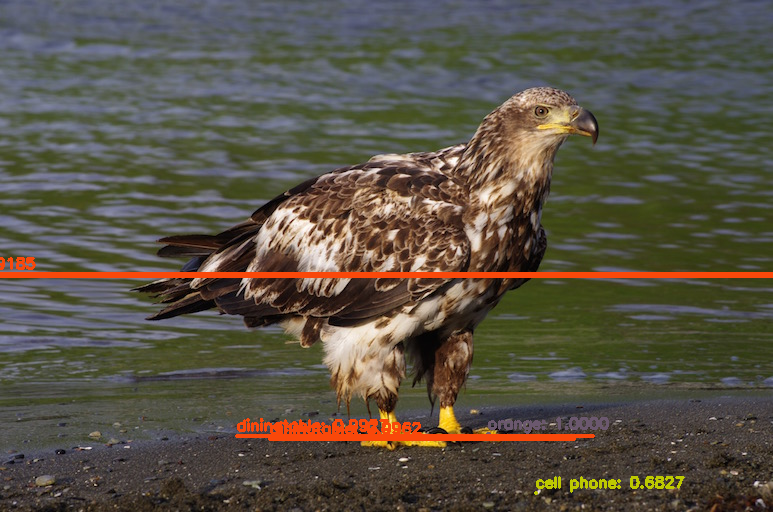

In [0]:
# fancy: initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(labels), 3),	dtype="uint8")

if len(idxs) > 0:
  for i in idxs.flatten():
    (x,y) = (boxes[i][0], boxes[i][1])
    (w,h) = (boxes[i][2], boxes[i][3])
    color = [int(c) for c in COLORS[classIDs[i]]]
    cv2.rectangle(image, (x,y), (x+w, y+h), color, 2)
    text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
    cv2.putText(image, text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

cv2_imshow(image)

## (Test)

In [0]:
#cv2_imshow(image)
idxs

array([[3],
       [0],
       [1]], dtype=int32)